In [1]:
%load_ext autoreload
%autoreload 2

# Topic Modeling avec LDA pour l'extraction des aspects explicites

l'objectif dans cette implementation est extraction des aspect explicite avec l'appliction de modèle Latent Dirichilet Allocation (LDA).

## Importation des bibliothèques

In [2]:
import os
os.chdir("..")

In [4]:
from nltk.corpus import stopwords
import re
import seaborn as sns
from time import time
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

import pyLDAvis.gensim_models
import pyLDAvis
pyLDAvis.enable_notebook()

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from IPython.display import HTML

## Fonction de pretraitement des datasets

La fonction prend un dictionnaire de jeux de données. il a comme clé un nom pour identifier le dataset et comme valeur le chemin vers le dataset.

Le prétraitement appliqué compose les opération suivantes:

**Nettoyage des commentaires (fonction clean_datasets)**
- suppression des caractères inutile;
- transformation en minuscule;
- correction des fautes d'orthographe;
- suppression des phrases objectifs;
- suppression des commentaires vides après les opérations précédents;


In [5]:
def clean_datasets(datasets):
    cleaned_datasets = []
    for dataset_name in datasets:
        print(f"cleaning dataset {dataset_name}")
        dataset = pd.read_csv(datasets[dataset_name])
        old = time()
        review_preprocessor = ReviewPreprocessor(dataset['review'], nlp)
        dataset['cleaned_data'] = review_preprocessor.remove_tags()
        dataset['cleaned_data'] = review_preprocessor.lowercase_transformation()
        dataset['cleaned_data'] = review_preprocessor.pararel_spelling_correction()
        dataset['cleaned_data'] = review_preprocessor.remove_objective_sentences()
        dataset = dataset[dataset['cleaned_data'] != ""]
        print(f"cleaning {dataset_name} took {time() - old}")
        cleaned_datasets.append((dataset_name, dataset))
    return cleaned_datasets

**Application de prétraitement**

In [6]:
old = time()
datasets = {'tripadvisor': 'data/3 datasets/reviews_TripAdvisor_2022_5_20_11_27_56_ 10pages_10hotels.csv',
                    'booking': 'data/3 datasets/reviews_Booking_2022_5_20_11_9_54_10links_10_pages.csv',
                    'agoda': 'data/3 datasets/reviews_Agoda_2022_5_20_10_58_5_10pages_10_links.csv',
                    'agoda_london':'data/3 datasets/reviews_Agoda_2022_5_21_11_32_11_London_5pages_5links.csv',
                    'tripadvisor_london': 'data/3 datasets/reviews_TripAdvisor_2022_5_21_11_51_26_london_5pages_5links.csv'}
cleaned_datasets = clean_datasets(datasets)
print(f"duration : {time() - old}")

cleaning dataset tripadvisor


2141it [01:02, 34.06it/s]


cleaning tripadvisor took 339.90865302085876
cleaning dataset booking


1022it [00:14, 71.89it/s]


cleaning booking took 41.76488256454468
cleaning dataset agoda


230it [00:03, 61.92it/s]


cleaning agoda took 25.807928800582886
cleaning dataset agoda_london


245it [00:04, 53.41it/s]


cleaning agoda_london took 29.42093062400818
cleaning dataset tripadvisor_london


658it [00:26, 25.26it/s]

cleaning tripadvisor_london took 98.36129260063171
duration : 538.3970093727112


## Fonction de création de corpus pour l'entraînement de modèle LDA

**construction de corpus pour entraînement de LDA (fonction create_lda_corpus)**
- transformation des des commentaires en phrases;
- tokenization des commentaires ;
- suppression des stopwords.

In [7]:
_stopwords = stopwords.words('english')

In [8]:
def create_lda_corpus(datasets):
    tokenized_datasets = dict()
    for dataset in datasets:
        dataset_name = dataset[0]
        dataset_sentences = []
        print(f"cleaning dataset {dataset_name}")
        old = time()
        cleaned_reviews = dataset[1]['cleaned_data']
        for i, review in cleaned_reviews.items():
            review = nlp(review)            
            for sentence in review.sents:
                _sent = []
                for token in sentence:
                    # remove ponctuation
                    token = re.sub(r'[^\w\s]', '', token.text)
                    # add tokent to _sent when it is not a stopword and not short (less than two chars)
                    if len(token) >= 2 and token not in _stopwords:
                        _sent.append(token)
                dataset_sentences.append(_sent)
        tokenized_datasets[dataset_name] = dataset_sentences
        print(f"duration to tokenize dataset {dataset_name} is {time() - old}s")
    return tokenized_datasets


In [9]:
t = time()
tokenized_datasets = create_lda_corpus(cleaned_datasets)
print(f"time to tokenize all datasets is {time() - t}")

cleaning dataset tripadvisor
duration to tokenize dataset tripadvisor is 40.950488567352295s
cleaning dataset booking
duration to tokenize dataset booking is 8.662747621536255s
cleaning dataset agoda
duration to tokenize dataset agoda is 2.246220350265503s
cleaning dataset agoda_london
duration to tokenize dataset agoda_london is 2.766796827316284s
cleaning dataset tripadvisor_london
duration to tokenize dataset tripadvisor_london is 11.633525133132935s
time to tokenize all datasets is 66.26077246665955


## Entraînement de modèle LDA.

In [9]:
all_id2word = dict()
all_corpus = dict()
for dataset in tokenized_datasets:
    all_id2word[dataset] = Dictionary(tokenized_datasets[dataset])
    all_corpus[dataset] = [all_id2word[dataset].doc2bow(text) for text in tokenized_datasets[dataset]]

In [10]:
def best_topic_number(tokenized_datasets, id2word, corpus, alpha = 0.2, eta = 0.3, start = 3, end=50, step=5):
    models = []
    for dataset in tokenized_datasets:
        print(f"working on {dataset} dataset")
        dataset_models = dict()
        coherences = []
        _old = time()
        for n_topic in range(start, end, step):
            __old = time()
            print(f"training lda model for {n_topic} topic")
            lda_model = LdaMulticore(corpus=corpus[dataset],
                                       id2word=id2word[dataset],
                                       num_topics=n_topic,
                                       random_state=42,
                                       chunksize=15,
                                       passes=10,
                                       iterations=5,
                                       alpha=alpha,
                                       eta=eta,
                                      workers = 4)
            print(f"calculating coherence")
            coherences.append(CoherenceModel(model=lda_model,
                           texts=tokenized_datasets[dataset],
                           dictionary=id2word[dataset],
                           coherence='c_v').get_coherence())
            dataset_models[str(n_topic)] = lda_model
            print(f"===================> {time() - __old}")
        print(f"total time on {dataset} is {time()-_old}")
        models.append((dataset, dataset_models, coherences))
    return models

### Entraînement de LDA avec un nombre de topics de 3 à 30 et un pas de 3.

In [ ]:
old = time()
t = best_topic_number(tokenized_datasets, all_id2word, all_corpus, start=3, end=30,step=3)
print(f"duration : {time()-old}")

Le temps total d'entraînement des modèles LDA est de 867s <=> 14min

In [12]:
all_results = []
for i in t:
    coherences = []
    topics = []
    for _i, topic in enumerate(i[1]):
        topics.append(int(topic))
        coherences.append(i[2][_i])
    all_results.append((i[0], topics, coherences))

### Changement de coherence en fonction de nombre de topics extraite

#### TripAdvisor dataset

[Text(0.5, 1.0, 'lda coherence results on tripadvisor dataset')]

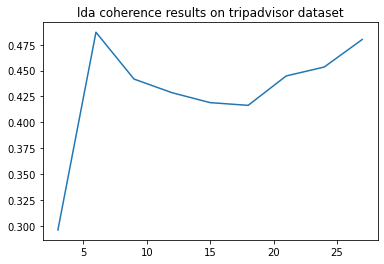

In [13]:
sns.lineplot(x=all_results[0][1], y=all_results[0][2]).set(title = "lda coherence results on tripadvisor dataset")

**Valeur de cohérence maximale et nombre du topics correspondant.**

In [14]:
max(all_results[0][2]), all_results[0][1][all_results[0][2].index(max(all_results[0][2]))]

(0.4870584015932558, 6)

In [66]:
pyLDAvis.save_html(pyLDAvis.gensim_models.prepare(t[0][1]['6'], corpus=all_corpus['tripadvisor'], dictionary=all_id2word['tripadvisor']), "tripadvisor_3_30_6.html")

e:\pychcarmprojects\s4\servqc_ml\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


[consulter le fichier /lda_graphs/tripadvisor_3_30_6.html](../lda_graphs/tripadvisor_3_30_6.html)

In [8]:
# HTML(filename='../lda_graphs/tripadvisor_3_30_6.html')

In [72]:
t[0][1]['6'].print_topics()

[(0,
  '0.091*"room" + 0.041*"clean" + 0.038*"rooms" + 0.033*"small" + 0.025*"comfortable" + 0.017*"bathroom" + 0.015*"hotel" + 0.015*"nice" + 0.013*"well" + 0.013*"shower"'),
 (1,
  '0.091*"staff" + 0.048*"breakfast" + 0.047*"friendly" + 0.041*"helpful" + 0.039*"good" + 0.030*"service" + 0.029*"nice" + 0.024*"hotel" + 0.018*"excellent" + 0.017*"great"'),
 (2,
  '0.089*"hotel" + 0.050*"stay" + 0.039*"would" + 0.035*"paris" + 0.017*"recommend" + 0.015*"definitely" + 0.015*"stayed" + 0.015*"garden" + 0.011*"wonderful" + 0.011*"place"'),
 (3,
  '0.031*"free" + 0.029*"breakfast" + 0.021*"day" + 0.020*"drinks" + 0.019*"bar" + 0.018*"also" + 0.017*"coffee" + 0.014*"snacks" + 0.014*"nice" + 0.014*"food"'),
 (4,
  '0.047*"location" + 0.040*"hotel" + 0.036*"great" + 0.022*"walk" + 0.021*"metro" + 0.017*"good" + 0.016*"eiffel" + 0.016*"close" + 0.014*"tower" + 0.014*"restaurants"'),
 (5,
  '0.030*"nt" + 0.021*"one" + 0.020*"us" + 0.018*"night" + 0.013*"could" + 0.011*"get" + 0.009*"even" + 0.008

#### Booking dataset

[Text(0.5, 1.0, 'lda coherence results on booking dataset')]

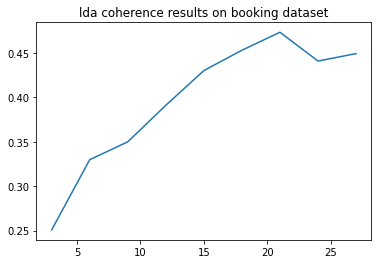

In [16]:
sns.lineplot(x=all_results[1][1], y=all_results[1][2]).set(title = "lda coherence results on booking dataset")

**Valeur de cohérence maximale et nombre du topics correspondant.**

In [17]:
max(all_results[1][2]), all_results[1][1][all_results[1][2].index(max(all_results[1][2]))]

(0.4734682138808609, 21)

In [64]:
pyLDAvis.save_html(pyLDAvis.gensim_models.prepare(t[1][1]['21'], corpus=all_corpus['booking'], dictionary=all_id2word['booking']), "booking_3_30_21.html")

e:\pychcarmprojects\s4\servqc_ml\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


[consulter le fichier /lda_graphs/booking_3_30_21.html](../lda_graphs/booking_3_30_21.html)

In [7]:
# HTML(filename='../lda_graphs/booking_3_30_21.html')

In [73]:
t[1][1]['21'].print_topics()

[(7,
  '0.039*"bit" + 0.030*"little" + 0.013*"quality" + 0.011*"light" + 0.011*"far" + 0.009*"walls" + 0.009*"photos" + 0.009*"taxi" + 0.008*"looked" + 0.007*"decent"'),
 (1,
  '0.041*"could" + 0.036*"also" + 0.024*"area" + 0.019*"parking" + 0.017*"sleep" + 0.017*"luggage" + 0.016*"safe" + 0.015*"people" + 0.012*"hotel" + 0.010*"quiet"'),
 (10,
  '0.056*"everything" + 0.047*"like" + 0.041*"uncomfortable" + 0.019*"beds" + 0.015*"old" + 0.008*"turn" + 0.006*"pillows" + 0.006*"else" + 0.005*"bed" + 0.004*"soft"'),
 (2,
  '0.040*"price" + 0.034*"bad" + 0.033*"service" + 0.016*"leave" + 0.015*"smell" + 0.015*"hotel" + 0.014*"noisy" + 0.014*"windows" + 0.012*"staffs" + 0.010*"customer"'),
 (11,
  '0.040*"hotel" + 0.039*"metro" + 0.032*"near" + 0.025*"station" + 0.025*"perfect" + 0.023*"much" + 0.022*"location" + 0.022*"paris" + 0.020*"close" + 0.019*"problem"'),
 (5,
  '0.094*"bathroom" + 0.054*"tiny" + 0.025*"day" + 0.024*"tidy" + 0.023*"heating" + 0.014*"every" + 0.013*"two" + 0.010*"worke

#### Agoda dataset

[Text(0.5, 1.0, 'lda coherence results on agoda dataset')]

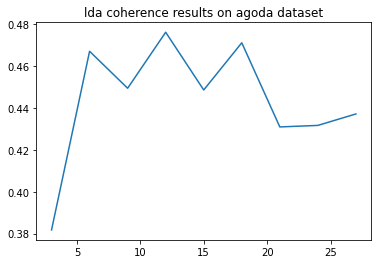

In [19]:
sns.lineplot(x=all_results[2][1], y=all_results[2][2]).set(title = "lda coherence results on agoda dataset")

**Valeur de cohérence maximale et nombre du topics correspondant.**

In [20]:
max(all_results[2][2]), all_results[2][1][all_results[2][2].index(max(all_results[2][2]))]

(0.4760930970410149, 12)

In [62]:
pyLDAvis.save_html(pyLDAvis.gensim_models.prepare(t[2][1]['12'], corpus=all_corpus['agoda'], dictionary=all_id2word['agoda']), "agoda_3_30_12.html")

e:\pychcarmprojects\s4\servqc_ml\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


[consulter le fichier /lda_graphs/agoda_3_30_12.html](../lda_graphs/agoda_3_30_12.html)

In [15]:
# HTML(filename='../lda_graphs/agoda_3_30_12.html')

In [75]:
t[2][1]['12'].print_topics()

[(0,
  '0.017*"hot" + 0.013*"hotels" + 0.009*"better" + 0.009*"size" + 0.008*"water" + 0.007*"shower" + 0.006*"warm" + 0.005*"service" + 0.005*"able" + 0.005*"time"'),
 (1,
  '0.031*"breakfast" + 0.021*"nt" + 0.014*"check" + 0.014*"get" + 0.013*"hotel" + 0.012*"free" + 0.010*"hour" + 0.009*"even" + 0.009*"experience" + 0.009*"area"'),
 (2,
  '0.077*"staff" + 0.033*"friendly" + 0.032*"helpful" + 0.029*"airport" + 0.021*"hotel" + 0.015*"bus" + 0.011*"time" + 0.010*"cog" + 0.010*"enjoyed" + 0.009*"351"'),
 (3,
  '0.010*"many" + 0.008*"new" + 0.008*"options" + 0.008*"terrible" + 0.008*"tiny" + 0.006*"one" + 0.005*"hard" + 0.005*"view" + 0.005*"works" + 0.005*"surprised"'),
 (4,
  '0.021*"quite" + 0.019*"little" + 0.016*"perfect" + 0.015*"wifi" + 0.010*"safe" + 0.009*"bit" + 0.009*"far" + 0.008*"ok" + 0.007*"fast" + 0.007*"know"'),
 (5,
  '0.168*"room" + 0.128*"small" + 0.046*"tooooooooooo" + 0.046*"nooooooo" + 0.030*"clean" + 0.022*"rooms" + 0.012*"bed" + 0.005*"restaurant" + 0.005*"kind" 

#### Agoda_london dataset

[Text(0.5, 1.0, 'lda coherence results on agoda_london dataset')]

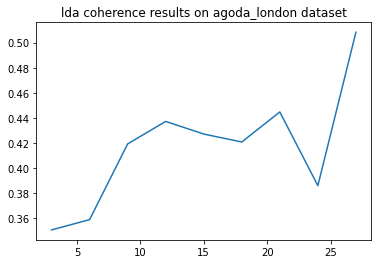

In [22]:
sns.lineplot(x=all_results[3][1], y=all_results[3][2]).set(title = "lda coherence results on agoda_london dataset")

**Valeur de cohérence maximale et nombre du topics correspondant.**

In [23]:
max(all_results[3][2]), all_results[3][1][all_results[3][2].index(max(all_results[3][2]))]

(0.5082606379454042, 27)

In [60]:
# pyLDAvis.save_html(pyLDAvis.gensim_models.prepare(t[3][1]['27'], corpus=all_corpus['agoda_london'], dictionary=all_id2word['agoda_london']), "agoda_london_3_30_27.html")

e:\pychcarmprojects\s4\servqc_ml\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


[consulter le fichier /lda_graphs/agoda_london_3_30_27.html](../lda_graphs/agoda_london_3_30_27.html)

In [14]:
#HTML(filename='../lda_graphs/agoda_london_3_30_27.html')

In [76]:
t[3][1]['27'].print_topics()

[(14,
  '0.007*"holiday" + 0.006*"disappointed" + 0.006*"trip" + 0.004*"charged" + 0.004*"spoilt" + 0.004*"wasting" + 0.004*"spent" + 0.004*"conceded" + 0.004*"precious" + 0.004*"3h"'),
 (21,
  '0.014*"tv" + 0.004*"shared" + 0.003*"toilets" + 0.002*"wall" + 0.002*"dated" + 0.002*"get" + 0.002*"overall" + 0.002*"toiletries" + 0.002*"state" + 0.002*"unit"'),
 (17,
  '0.022*"wifi" + 0.020*"excellent" + 0.013*"time" + 0.009*"make" + 0.009*"hotel" + 0.009*"open" + 0.008*"able" + 0.008*"budget" + 0.008*"check" + 0.008*"front"'),
 (11,
  '0.033*"could" + 0.032*"stay" + 0.014*"airport" + 0.008*"outdated" + 0.008*"fine" + 0.008*"facilities" + 0.007*"larger" + 0.007*"maintenance" + 0.007*"enjoyed" + 0.007*"heathrow"'),
 (2,
  '0.012*"windows" + 0.004*"floors" + 0.004*"deep" + 0.003*"opened" + 0.002*"flow" + 0.002*"shuttered" + 0.002*"looked" + 0.002*"pleased" + 0.002*"facilities" + 0.002*"air"'),
 (4,
  '0.021*"like" + 0.019*"service" + 0.011*"value" + 0.011*"whole" + 0.010*"cleaning" + 0.008*"h

#### TripAdvisor_london dataset

[Text(0.5, 1.0, 'lda coherence results on tripadvisor_london dataset')]

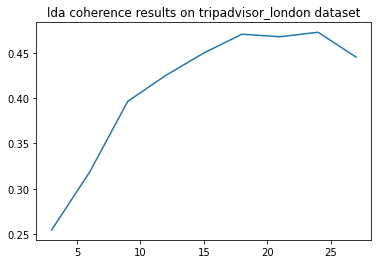

In [25]:
sns.lineplot(x=all_results[4][1], y=all_results[4][2]).set(title = "lda coherence results on tripadvisor_london dataset")

**Valeur de cohérence maximale et nombre du topics correspondant.**

In [26]:
max(all_results[4][2]), all_results[4][1][all_results[4][2].index(max(all_results[4][2]))]

(0.4727411057468282, 24)

In [59]:
pyLDAvis.save_html(pyLDAvis.gensim_models.prepare(t[4][1]['24'], corpus=all_corpus['tripadvisor_london'], dictionary=all_id2word['tripadvisor_london']), "tripadvisor_london_3_30_24.html")

e:\pychcarmprojects\s4\servqc_ml\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


[consulter le fichier /lda_graphs/tripadvisor_london_3_30_24.html](../lda_graphs/tripadvisor_london_3_30_24.html)

In [17]:
# HTML(filename='../lda_graphs/tripadvisor_london_3_30_24.html')

In [77]:
t[4][1]['24'].print_topics()

[(15,
  '0.031*"restaurant" + 0.029*"view" + 0.018*"offered" + 0.016*"drinks" + 0.013*"guest" + 0.012*"safe" + 0.011*"complimentary" + 0.011*"going" + 0.010*"nearby" + 0.009*"available"'),
 (4,
  '0.101*"room" + 0.059*"staff" + 0.036*"clean" + 0.035*"hotel" + 0.031*"friendly" + 0.023*"nice" + 0.023*"rooms" + 0.022*"bed" + 0.022*"comfortable" + 0.021*"helpful"'),
 (18,
  '0.026*"sleep" + 0.019*"quite" + 0.013*"part" + 0.009*"large" + 0.009*"throughout" + 0.008*"took" + 0.008*"dry" + 0.007*"iron" + 0.006*"wifi" + 0.005*"needs"'),
 (14,
  '0.024*"lobby" + 0.012*"gorgeous" + 0.010*"book" + 0.009*"quick" + 0.008*"impressed" + 0.008*"ceiling" + 0.006*"professional" + 0.005*"freezing" + 0.005*"elevators" + 0.004*"telephone"'),
 (9,
  '0.024*"open" + 0.017*"end" + 0.017*"door" + 0.016*"deluxe" + 0.011*"right" + 0.010*"across" + 0.010*"personal" + 0.006*"west" + 0.005*"nearly" + 0.005*"world"'),
 (1,
  '0.116*"great" + 0.066*"location" + 0.059*"london" + 0.036*"excellent" + 0.028*"hotel" + 0.02

#### Tableau récapitulatif.

| dataset            | nombre de commentaires | nombre de phrases | nombre moyenne de mots par phrase | valeur de coherence | nombrer de topic |
|--------------------|------------------------|-------------------|-----------------------------------|---------------------|------------------|
| tripadvisor        | 2141                   | 10180             | 8                                 | 0.487               | 6                |
| booking            | 1022                   | 2001              | 6                                 | 0.473               | 21               |
| agoda              | 230                    | 452               | 6                                 | 0.476               | 12               |
| agoda_london       | 245                    | 585               | 7                                 | 0.508               | 27               |
| tripadvisor_london | 658                    | 3043              | 8                                 | 0.473               | 24               |

#### Conclusions

- Dans les petits jeux de données (agoda, agoda_london, tripadvisor_london, booking) le nombre de topics extraits et grands, mais la plupart des topics composés des adjectifs est ne suffis pas de déduire un nom de topics.
- D'après la visualisation des topics, nous remarquons que les majorités des topics se regroupent dans la même région car ils se composent des mêmes mots.
- Dans le dataset tripadvisor grand par rapport aux jeux des données précédentes, nous remarquons que le nombre de topics optimaux (la valeur de coherence le plus grand) sont petits. Si on analyse les mots qui contribuent aux topics, on remarque qu'il permet de déduire les topics. Exemple :
    - **Topic 0**: `room , clean, rooms, small, comfortable, bathroom, hotel, nice, well, shower` (discute l'aspect room)
    - **Topic 1**: `staff, breakfast, friendly, helpful, good, service, nice, hotel, excellent, great` (discute l'aspect service)
    - **Topic 2**: `hotel, stay, would, paris, recommend, definitely, stayed, garden, wonderful, place` (discute l'aspect hotel
    - **Topic 3**: `free, breakfast, day, drinks, bar, also, coffee, snacks, nice, food` (discute l'aspect food)
    - **Topic 4** `location, hotel, great, walk, metro, good, eiffel, close, tower, restaurants` (discute l'aspect location
    - **Topic 5**: `nt, one, us, night, could, get, even, time, better, check.` (ne pouvons pas déduire un aspects)
- la valeur de coherence dans les 5 modèles de LDA est petite, car le modèle LDA est moins performant pour les petits textes.

### Entraînement de modèle LDA sur l'ensemble des datasets

Dans cette partie nous regroupons les dataset dans une seul pour entraîner le modèle LDA. également nous diminuons l'intervale de nombre de topics (3 à 13 avec un pas de 1).

In [10]:
def best_topic_number_one_dataset(tokenized_datasets, id2word, corpus, alpha = 0.2, eta = 0.3, start = 3, end=50, step=5):
    models = []
    coherences = []
    _old = time()
    for n_topic in range(start, end, step):
        __old = time()
        print(f"training lda model for {n_topic} topic")
        lda_model = LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=n_topic,
                                   random_state=42,
                                   chunksize=15,
                                   passes=10,
                                   iterations=5,
                                   alpha=alpha,
                                   eta=eta,
                                  workers = 4)
        print(f"calculating coherence")
        coherences.append(CoherenceModel(model=lda_model,
                       texts=tokenized_datasets,
                       dictionary=id2word,
                       coherence='c_v').get_coherence())
        models.append(lda_model)
        print(f"===================> {time() - __old}")
    print(f"total time on is {time()-_old}")
    return models, coherences

#### Groupement des datasets dans une seul

In [11]:
merged_datasets = []
for data in tokenized_datasets:
    for sentence in tokenized_datasets[data]:
        merged_datasets.append(sentence)
    

In [12]:
merged_id2word = Dictionary(merged_datasets)
merged_corpus = [merged_id2word.doc2bow(text) for text in merged_datasets]

In [14]:
lda_models, coherences = best_topic_number_one_dataset(merged_datasets,
                                                       merged_id2word,
                                                       merged_corpus,
                                                       start=6, end=7, step=1)

training lda model for 6 topic
calculating coherence
===================> 58.88210892677307
total time on is 58.88210892677307


La durée totale d'entraînement des modèles LDA est de 453s <=> 7 min

In [ ]:
sns.lineplot(x = list(range(3,12,1)), y = coherences).set(title="coherence results of training lda model on merged datasets")

In [ ]:
(max(coherences), list(range(3,12,1))[coherences.index(max(coherences))])

In [ ]:
pyLDAvis.save_html(pyLDAvis.gensim_models.prepare(lda_models[coherences.index(max(coherences))], corpus=merged_corpus, dictionary=merged_id2word), "lda_graphs/merged_datasets.html")

[consulter le fichier /lda_graphs/merged_datasets.html]('../lda_graphs/merged_datasets.html')

In [35]:
# HTML(filename='../lda_graphs/merged_datasets.html')

In [15]:
lda_models[coherences.index(max(coherences))].print_topics()

[(0,
  '0.025*"nt" + 0.024*"room" + 0.019*"could" + 0.017*"one" + 0.016*"night" + 0.015*"bar" + 0.012*"even" + 0.012*"stayed" + 0.011*"free" + 0.010*"time"'),
 (1,
  '0.052*"breakfast" + 0.037*"good" + 0.020*"shower" + 0.016*"food" + 0.012*"nt" + 0.011*"hot" + 0.010*"water" + 0.009*"restaurant" + 0.009*"enough" + 0.009*"bit"'),
 (2,
  '0.095*"room" + 0.051*"clean" + 0.034*"rooms" + 0.029*"small" + 0.028*"comfortable" + 0.025*"bed" + 0.018*"nice" + 0.018*"hotel" + 0.016*"well" + 0.015*"bathroom"'),
 (3,
  '0.088*"staff" + 0.039*"friendly" + 0.030*"helpful" + 0.028*"us" + 0.018*"check" + 0.016*"made" + 0.016*"reception" + 0.014*"service" + 0.013*"hotel" + 0.011*"nice"'),
 (4,
  '0.049*"location" + 0.025*"hotel" + 0.020*"walk" + 0.016*"good" + 0.016*"great" + 0.015*"many" + 0.014*"station" + 0.014*"easy" + 0.013*"close" + 0.013*"area"'),
 (5,
  '0.075*"hotel" + 0.057*"stay" + 0.052*"great" + 0.035*"would" + 0.019*"lovely" + 0.017*"location" + 0.017*"amazing" + 0.017*"london" + 0.016*"good

In [16]:
lda_model = lda_models[coherences.index(max(coherences))]

In [32]:
lda_model[merged_id2word.doc2bow(["the location great because it's close to many restaurants"][0].split())]

[(0, 0.032258373),
 (1, 0.0322584),
 (2, 0.03225839),
 (3, 0.03225839),
 (4, 0.8362935),
 (5, 0.034672968)]

le modèle LDA a classifié cette phrase dans le topic location avec une proportion de 86.6%, effectivement ces le bon aspect.

#### Application manuelle du modèle LDA sur des commentaires choisit aléatoirement.

##### Sur le commentaire avec l'identifiant 5

In [38]:
cleaned_datasets[0][1].loc[5,'cleaned_data']

" clean little hotel with amazing staff, they were always friendly and helpful with any advice i needed about getting around etc..location perfect, cafes and restaurants are nearby and best of all 5 minutes walk to eiffel tower. would definitely stay again and will recommend to anyone who's going paris."

**1er phrase**

clean little hotel with amazing staff, they were always friendly and helpful with any advice i needed about getting around etc

In [39]:
lda_model[merged_id2word.doc2bow(["clean little hotel with amazing staff, they were always friendly and helpful with any advice i needed about getting around etc"][0].split())]

[(0, 0.015429627),
 (1, 0.054572135),
 (2, 0.16470857),
 (3, 0.39119586),
 (4, 0.24531485),
 (5, 0.12877898)]

le modèle classifie cette phrase dans l'aspet car il contient le nom staff et les adjectif friendly et helpful lié à aspect staff. Mais ce n'est pas le cas car il discute également l'aspect hotel.

**2ème phrase**

location perfect, cafes and restaurants are nearby and best of all 5 minutes walk to eiffel tower.

In [40]:
lda_model[merged_id2word.doc2bow(["location perfect, cafes and restaurants are nearby and best of all 5 minutes walk to eiffel tower."][0].split())]

[(0, 0.021740347),
 (1, 0.021740438),
 (2, 0.021740438),
 (3, 0.021745887),
 (4, 0.7812834),
 (5, 0.13174947)]

l'aspect extrait par le modèle est location ce qu'est bien le cas.

**3ème phrase**

In [41]:
lda_model[merged_id2word.doc2bow(["would definitely stay again and will recommend to anyone who's going paris."][0].split())]

[(0, 0.17043285),
 (1, 0.027780179),
 (2, 0.027780069),
 (3, 0.02778018),
 (4, 0.027781144),
 (5, 0.71844554)]

le modèle identifie cette phrase qu'il discute l'aspect hotel, ce qui est le cas car il s'agit d'une recommendation de l'hotel.

--------------------------------------------

##### Sur le commentaire avec l'identifiant 15

loved this little hotel! room was nice! in city center, close to the eiffel tower, metro, bus routes, cafes, pastry shops, the river. staff was amazing and always helpful! would gladly stay again!

In [42]:
cleaned_datasets[0][1].loc[15, 'cleaned_data']

' loved this little hotel! room was nice! in city center, close to the eiffel tower, metro, bus routes, cafes, pastry shops, the river. staff was amazing and always helpful! would gladly stay again!'

**1er phrase**

In [43]:
lda_model[merged_id2word.doc2bow(["loved this little hotel"][0].split())]

[(0, 0.048409462),
 (1, 0.048298616),
 (2, 0.078511104),
 (3, 0.047704764),
 (4, 0.048415907),
 (5, 0.7286601)]

le modèle identifie cette phrase qu'il discute le topic hotel, ce qui est le cas car.

**2ème phrase**

In [45]:
lda_model[merged_id2word.doc2bow(["in city center, close to the eiffel tower, metro, bus routes, cafes, pastry shops, the river."][0].split())]

[(0, 0.032276664),
 (1, 0.18902697),
 (2, 0.03227586),
 (3, 0.032276586),
 (4, 0.68177444),
 (5, 0.03236944)]

le modèle classifie cette phrase dans le topic location et ce qui est le cas car il contient les mots de places.

**3ème phrase**

In [46]:
lda_model[merged_id2word.doc2bow(["staff was amazing and always helpful"][0].split())]

[(0, 0.03846227),
 (1, 0.038462363),
 (2, 0.038462356),
 (3, 0.6154561),
 (4, 0.038462367),
 (5, 0.23069459)]

le modèle classifie la phrase dans le topic staff ce qui est bien le cas. également dans le topic hôtel avec un pourcentage de 23% car il contient des mots dans ce topic.

**4ème phrase**

In [47]:
lda_model[merged_id2word.doc2bow(["would gladly stay again!"][0].split())]

[(0, 0.047723703),
 (1, 0.04763057),
 (2, 0.047630526),
 (3, 0.047631167),
 (4, 0.047631778),
 (5, 0.7617522)]

le modèle classifie cette phrase dans le topic hôtel ce qui bien le cas.

---------------------------------------

##### Sur le commentaire avec l'identifiant 30

In [48]:
cleaned_datasets[0][1].loc[30,'cleaned_data']

' great location 10 mins walk to eiffel tower. 5 mins walk to metro, safe neighborhood, very friendly staff, very clean and comfortable. breakfast could be better but it was ok.'

**1er phrase**

In [49]:
lda_model[merged_id2word.doc2bow(["great location 10 mins walk to eiffel tower"][0].split())]

[(0, 0.024390766),
 (1, 0.024390806),
 (2, 0.024390804),
 (3, 0.024390794),
 (4, 0.8775482),
 (5, 0.024888627)]

le modèle LDA classifie cette phrase dans le topic location, ce qui est bien le cas.

**2ème phrase**

In [50]:
lda_model[merged_id2word.doc2bow(["5 mins walk to metro, safe neighborhood, very friendly staff, very clean and comfortable."][0].split())]

[(0, 0.032259665),
 (1, 0.032259736),
 (2, 0.29245794),
 (3, 0.19357987),
 (4, 0.41718307),
 (5, 0.032259755)]

le modèle classifie cette phrase dans le topic location avec un pourcentage de 41%, et dans le topic room avec un pourcentage 29% et dans le topic staff avec un pourcentage 19%.

**3ème phrase**

In [53]:
lda_model[merged_id2word.doc2bow(["breakfast could be better but it was ok."][0].split())]

[(0, 0.285464),
 (1, 0.28600967),
 (2, 0.047620572),
 (3, 0.047620583),
 (4, 0.047620628),
 (5, 0.2856646)]

le modèle classifie la phrase dans 3 topics avec un même pourcentage, lesquels : hotel, food, topic inconnue. ce qui est pas le cas.

#### Conclusions

- Après le groupement des datasets, nous remarquons que les topics extraits sont similaires à celles extraits depuis le dataset TripAdvisor avec des modifications au niveau des mots qui composent les topics.